#1. Get Data

In [1]:
## 1. Getting Data
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

!git clone https://github.com/mrdbourke/pytorch-deep-learning
!mv pytorch-deep-learning/going_modular .
!mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
!rm -rf pytorch-deep-learning
from going_modular.going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (223/223), done.
remote: Total 4036 (delta 1068), reused 1080 (delta 998), pack-reused 2812
Receiving objects: 100% (4036/4036), 651.02 MiB | 21.22 MiB/s, done.
Resolving deltas: 100% (2361/2361), done.
Updating files: 100% (248/248), done.
mv: cannot move 'pytorch-deep-learning/going_modular' to './going_modular': Directory not empty


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


PosixPath('data/pizza_steak_sushi_20_percent')

In [4]:
# Setup training path and testing path
train_dir = data_20_percent_path / 'train'
test_dir = data_20_percent_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

# 2. Creating an EffNetB2 Feature Extractor

In [5]:
import torchvision
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

# # 1. Setup pretrained EffNetB2 weights
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# # 2. Get EffNetB2 transforms
effnetb2_transforms = weights.transforms()

# # 3. Setup pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(weights=weights)

# # 4. Freeze the base layers in the model (this will stop all the layers from training)
for param in effnetb2.parameters():
  param.requires_grad = False

In [6]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [7]:
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p = 0.3, inplace = True),
    nn.Linear(in_features = 1408, out_features = 3, bias = True)
)

In [8]:
# !pip install torchinfo
# from torchinfo import summary

# summary(effnetb2,
#         input_size = (1, 3, 224, 224),
#         col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
#         col_width = 20,
#         row_settings = ['var_names'])

# 3.1 Creating a function to make an EffNetB2 feature extractor

In [9]:
def create_effnetb2_model(num_classes: int = 3,
                          seed: int = 42):
  # Create EffnetB2 pretrained weights and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights = weights)

  # Freeze all the layers in base model
  for params in model.parameters():
    params.require_grads = False

  # Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p = 0.3, inplace = True),
      nn.Linear(in_features = 1408, out_features = num_classes)
  )

  return model, transforms

In [10]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes = 3, seed = 42)

## 3.2 Creating DataLoaders for EffnetB2

In [11]:
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                                                 test_dir = test_dir,
                                                                                                 transform = effnetb2_transforms,
                                                                                                 batch_size = 32)

In [12]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

## 3.3 Training EffnetB2 Feature extractor

In [13]:
from going_modular.going_modular import engine

# loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params = effnetb2.parameters(),
                             lr = 1e-3)

# Training function
set_seeds()
effnetb2_results = engine.train(model = effnetb2,
                                train_dataloader = train_dataloader_effnetb2,
                                test_dataloader = test_dataloader_effnetb2,
                                epochs = 10,
                                optimizer = optimizer,
                                loss_fn = loss_fn,
                                device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4645 | train_acc: 0.8271 | test_loss: 0.1367 | test_acc: 0.9722
Epoch: 2 | train_loss: 0.2731 | train_acc: 0.9250 | test_loss: 0.1916 | test_acc: 0.9437
Epoch: 3 | train_loss: 0.2131 | train_acc: 0.9354 | test_loss: 0.1500 | test_acc: 0.9500
Epoch: 4 | train_loss: 0.1720 | train_acc: 0.9521 | test_loss: 0.0635 | test_acc: 0.9688
Epoch: 5 | train_loss: 0.2194 | train_acc: 0.9333 | test_loss: 0.0768 | test_acc: 0.9722
Epoch: 6 | train_loss: 0.4258 | train_acc: 0.9271 | test_loss: 0.0937 | test_acc: 0.9784
Epoch: 7 | train_loss: 0.3741 | train_acc: 0.9146 | test_loss: 0.2118 | test_acc: 0.9295
Epoch: 8 | train_loss: 0.3779 | train_acc: 0.9021 | test_loss: 0.2240 | test_acc: 0.9352
Epoch: 9 | train_loss: 0.1597 | train_acc: 0.9417 | test_loss: 0.1167 | test_acc: 0.9477
Epoch: 10 | train_loss: 0.1654 | train_acc: 0.9437 | test_loss: 0.1721 | test_acc: 0.9568


## 3.4 Inspecting EffNetB2 loss curves

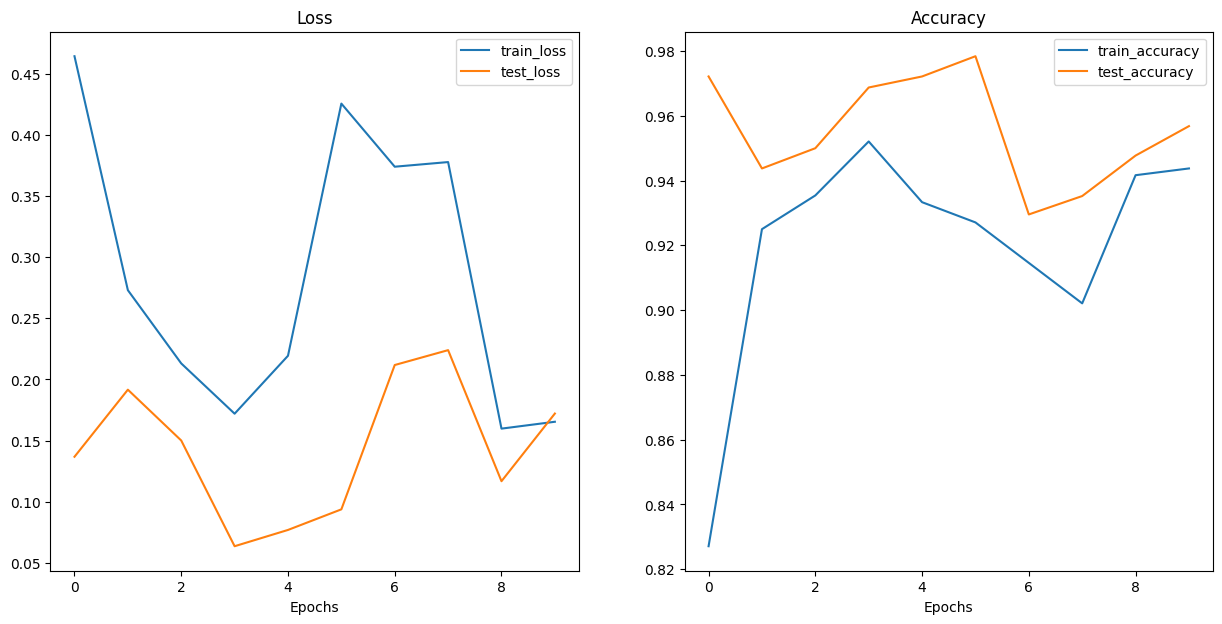

In [14]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

## 3.5 Saving EffnetB2 feature extractor

In [78]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model = effnetb2,
                 target_dir = 'models',
                 model_name = 'Pretrained_effnetb2_feature_extractor.pth')

[INFO] Saving model to: models/Pretrained_effnetb2_feature_extractor.pth


## 3.6 Inspecting the size of the saved model

In [16]:
from pathlib import Path

# Get the model size in bytes and convert to Megabytes
pretrained_effnetb2_model_size = Path('/content/models/Pretrained_effnetb2_feature_extractor.pth').stat().st_size / (1024 * 1024)
print(f'Pretrained EffNetB2 feature extractor model size: {round(pretrained_effnetb2_model_size, 2)} MB')

Pretrained EffNetB2 feature extractor model size: 29.84 MB


## 3.7 Collect EffNetB2 feature extractor stats

In [17]:
# Count number of parameters in effnetb2
effnetb2_total_params = sum(torch.numel(params) for params in effnetb2.parameters())
effnetb2_total_params

7705221

In [18]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {'test_loss': effnetb2_results['test_loss'][-1],
                  'test_acc': effnetb2_results['test_acc'][-1],
                  'number of parameters': effnetb2_total_params,
                  'model_size (MB)': pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.17207805216312408,
 'test_acc': 0.9568181818181818,
 'number of parameters': 7705221,
 'model_size (MB)': 29.84014320373535}

# 4. Creating a ViT feature extractor

In [19]:
# Check out the ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [20]:
def create_vit_model(num_classes: int = 3,
                     seed: int = 42):
  # Create ViT_B_16 pretrained weights, transforms and model
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  # Freeze all layers in model
  for param in model.parameters():
      param.requires_grad = False

  # Change classifier head to suit our needs (this will be trainable)
  torch.manual_seed(seed)
  model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                        out_features=num_classes)) # update to reflect target number of classes

  return model, transforms

In [21]:
vit, vit_transforms = create_vit_model()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [22]:
!pip install torchinfo

In [23]:
from torchinfo import summary

summary(vit,
        input_size = [1,3,224,224],
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

## 4.1 Create DataLoaders for ViT feature Extractor

In [24]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                                       test_dir = test_dir,
                                                                                       transform = vit_transforms,
                                                                                       batch_size = 32)
len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

## 4.2 Training ViT Feature Extractor

In [25]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params = vit.parameters(),
                             lr = 1e-3)

# Set up loss_fn
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT feature extractor
set_seeds()
vit_results = engine.train(model = vit,
                           train_dataloader = train_dataloader_vit,
                           test_dataloader = test_dataloader_vit,
                           epochs=10,
                           optimizer = optimizer,
                           loss_fn = loss_fn,
                           device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


## 4.3 Plot loss curves of ViT feature extractor

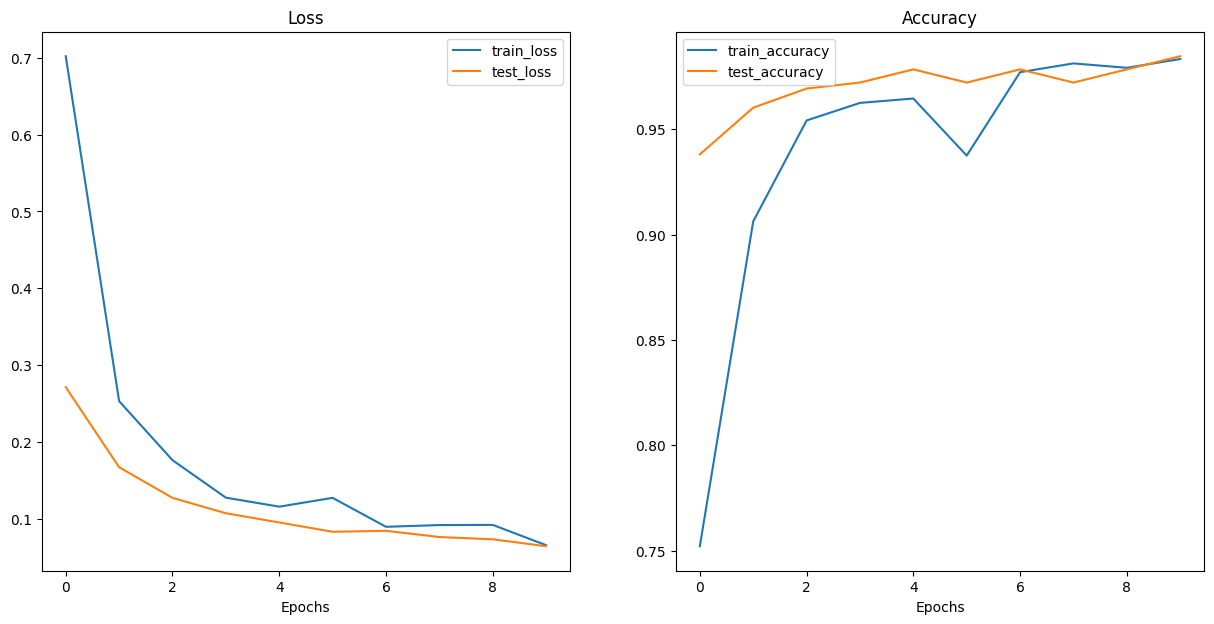

In [26]:
from helper_functions import plot_loss_curves
plot_loss_curves(vit_results)

## 4.4 Saving ViT Feature extractor model

In [27]:
# Save model
from going_modular.going_modular import utils

utils.save_model(model = vit,
                 target_dir = 'models',
                 model_name = 'pretrained_vit_feature_extractor.pth')

[INFO] Saving model to: models/pretrained_vit_feature_extractor.pth


## 4.5 Check the size of ViT Feature Extractor model

In [28]:
from pathlib import Path

# Get the model size in bytes and then convert it to Megabytes
vit_model_size = Path('/content/models/pretrained_vit_feature_extractor.pth').stat().st_size / (1024 * 1024)
print(f'Pretrained ViT Feature Extrator model size: {round(vit_model_size)} MB')

Pretrained ViT Feature Extrator model size: 327 MB


## 4.6 Collect ViT Feature extractor stats

In [29]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [30]:
# Create ViT Statistics dictionary
vit_stats = {'test_loss': vit_results['test_loss'][-1],
             'test_acc': vit_results['test_acc'][-1],
             'number_of_parameters':vit_total_params,
             'model_size (MB)': vit_model_size}

In [31]:
vit_stats

{'test_loss': 0.06443453514948487,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.3660259246826}

#5. Making Predictions with our trained models

In [32]:
from pathlib import Path

# Get all test_data paths
test_data_paths = list(Path(test_dir).glob('*/*.jpg'))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/670345.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1902895.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3553838.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3100563.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3757027.jpg')]

## 5.1 Creating a Function to make prediction across the test dataset

In [33]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer  as timer
from tqdm.auto import tqdm

from typing import List, Dict

def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = 'cuda' if torch.cuda.is_available() else 'cpu') -> List[Dict]:

  # 2. Create an empty list
  pred_list = []

  # 3. Loop through the target input paths
  for path in tqdm(paths):

    # 4. Create an empty dictionary for each sample
    pred_dict = {}

    # 5. Get the sample path and ground truth class from the filepath.
    pred_dict['image_path'] = path
    class_name = path.parent.stem
    pred_dict['class_name'] = class_name

    # 6. Start the prediction timer
    start_time = timer()

    # 7. Open the image using `PIL.Image.open(path)`
    img = Image.open(path)

    # 8. Transform image to be usable with given model
    transformed_image = transform(img).unsqueeze(0).to(device)

    # 9. Prepare the model for inference by sending to the target device
    model = model.to(device)
    model.eval()

    # 10. Turn on `Torch.inference_mode()` and pass the target transformed image
    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit, dim = 1) # Turn logits into prediction probabilities
      pred_label = torch.argmax(pred_prob, dim = 1) # Turn prediction probabilities into prediction labels
      pred_class = class_names[pred_label.cpu()] # prediction class on CPU

      # 11. Add the pred prob + pred class to empty dictionary from step 4.
      pred_dict['pred_prob'] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
      pred_dict['pred_class'] = pred_class

      # 12. End the prediction timer
      end_time = timer()
      pred_dict['time_for_pred'] = round(end_time - start_time, 4)

    # 13. See if the predicted class matches the ground truth class
    pred_dict['correct'] = class_name == pred_class

    # 14. Append the updated prediction to dictionary
    pred_list.append(pred_dict)

  # 15. Return the list of predictions dictionaries
  return pred_list

## 5.2 Making and timing predictions with EffNetB2

In [34]:
# Make predictions on test_dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths = test_data_paths,
                                          model = effnetb2,
                                          transform = effnetb2_transforms,
                                          class_names = class_names,
                                          device = 'cpu')

  0%|          | 0/150 [00:00<?, ?it/s]

In [35]:
effnetb2_test_pred_dicts[:1]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/670345.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9951,
  'pred_class': 'steak',
  'time_for_pred': 0.1754,
  'correct': True}]

In [36]:
# Turn the test_pred_dicts into a dataframe
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/6...,steak,0.9951,steak,0.1754,True
1,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9967,sushi,0.1648,False
2,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9876,steak,0.2092,True
3,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9983,steak,0.1598,True
4,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.8682,pizza,0.1439,False


In [37]:
effnetb2_test_pred_df.correct.value_counts()

True     144
False      6
Name: correct, dtype: int64

In [38]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f'EffNetB2 average time per prediction: {effnetb2_average_time_per_pred}')

EffNetB2 average time per prediction: 0.1666


In [39]:
# Add average time per prediction to ViT stats
effnetb2_stats['time_per_pred_cpu'] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.17207805216312408,
 'test_acc': 0.9568181818181818,
 'number of parameters': 7705221,
 'model_size (MB)': 29.84014320373535,
 'time_per_pred_cpu': 0.1666}

## 5.3 Making and timing predictions with ViT

In [40]:
# Make list of prediction dictionaries with ViT feature extractor model on test_images
vit_test_pred_dicts = pred_and_store(paths = test_data_paths,
                                     model = vit,
                                     transform = vit_transforms,
                                     class_names = class_names,
                                     device = 'cpu')

  0%|          | 0/150 [00:00<?, ?it/s]

In [41]:
vit_test_pred_dicts[:1]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/670345.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9985,
  'pred_class': 'steak',
  'time_for_pred': 0.714,
  'correct': True}]

In [42]:
# Turn the vit_test_pred_dicts
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/6...,steak,0.9985,steak,0.7140,True
1,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.5065,sushi,0.4554,False
2,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9180,steak,0.4144,True
3,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9890,steak,0.4170,True
4,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.4739,steak,0.4288,True


In [43]:
# See how many correct
vit_test_pred_df.correct.value_counts()

True     148
False      2
Name: correct, dtype: int64

In [44]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f'ViT average time per prediction: {vit_average_time_per_pred}')

ViT average time per prediction: 0.4611


In [45]:
# Add average time per prediction to ViT stats
vit_stats['time_per_pred_cpu'] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06443453514948487,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.3660259246826,
 'time_per_pred_cpu': 0.4611}

# 6. Comparing model results, prediction times and size

In [46]:
# Turn stats dictionary into dataframe
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df['model'] = ['EffNetB2', 'ViT']

# Convert accuracy to percentages
df['test_acc'] = round(df['test_acc'] * 100, 2)

df

,test_loss,test_acc,number of parameters,model_size (MB),time_per_pred_cpu,number_of_parameters,model
0,0.172078,95.68,7705221.0,29.840143,0.1666,NaN,EffNetB2
1,0.064435,98.47,NaN,327.366026,0.4611,85800963.0,ViT


In [47]:
# Compare EffNetB2 and ViT across different characteristics
pd.DataFrame(data = (df.set_index('model').loc['ViT'] / df.set_index('model').loc['EffNetB2']),
              columns = ['ViT to EffNetB2 ratios']).T


,test_loss,test_acc,number of parameters,model_size (MB),time_per_pred_cpu,number_of_parameters
ViT to EffNetB2 ratios,0.374449,1.02916,NaN,10.970659,2.767707,NaN


## 6.1 Visualizing the speed vs performance tradeoff

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


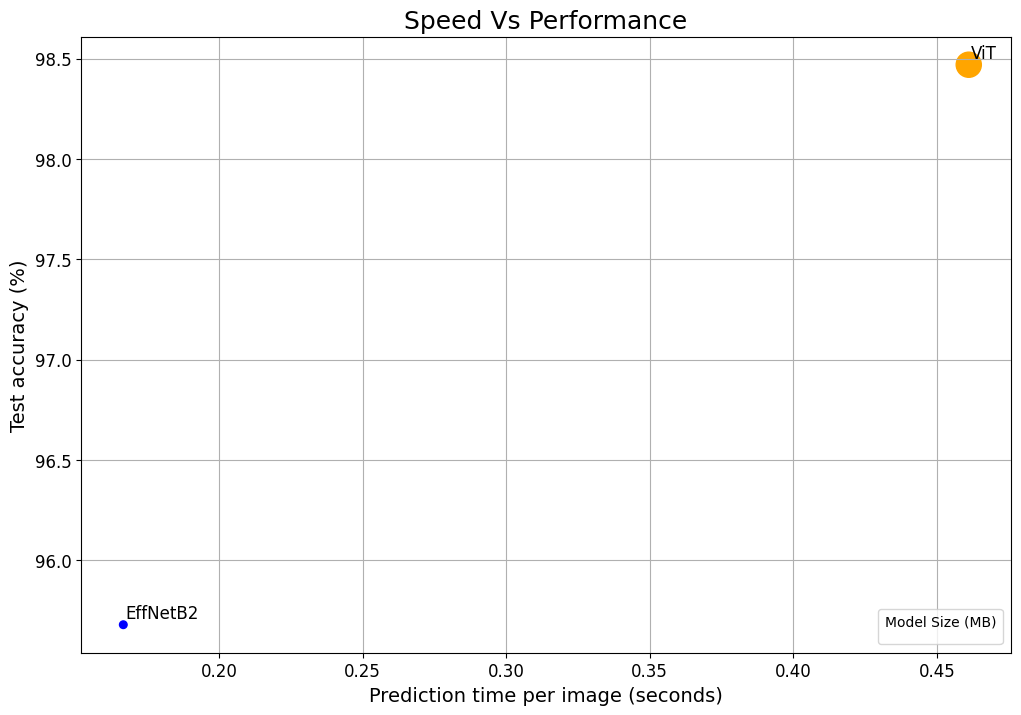

In [48]:
# 1. Create a plot from model comparison DataFrame
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data = df,
                     x = 'time_per_pred_cpu',
                     y = 'test_acc',
                     c = ['blue', 'orange'],
                     s = 'model_size (MB)')

# 2. Add title and labels
ax.set_title('Speed Vs Performance', fontsize = 18)
ax.set_xlabel('Prediction time per image (seconds)', fontsize = 14)
ax.set_ylabel('Test accuracy (%)', fontsize = 14)
ax.tick_params(axis = 'both', labelsize = 12)
ax.grid(True)

# 3. Annotate the samples on the scatter plot
for index, row in df.iterrows():
  ax.annotate(text = row['model'],
              xy = (row['time_per_pred_cpu']+0.0006, row['test_acc']+0.03),
              size = 12   )

# 4. Create a legend
handles, labels = scatter.legend_elements(props = 'sizes', alpha = 0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc = 'lower right',
                              title = 'Model Size (MB)',
                              fontsize = 12)
# Save the figure
plt.savefig('performance.png')

# 7. Gradio

In [49]:
!pip install -U pip
!pip install -U httpcore

In [50]:
!pip -q install gradio
import gradio as gr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 2.5 MB/s eta 0:00:00


## 7.1 Creating a function to map our inputs and outputs

In [52]:
# Put our model on cpu
effnetb2 = effnetb2.to('cpu')

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [54]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with effnetb2
  img = effnetb2_transforms(img).unsqueeze(0)

  # Put model into eval mode, make prediction
  effnetb2.eval()
  with torch.inference_mode():
    # Pass transformed image through the model and turn the prediction logits into probabilities
    pred_probs = torch.softmax(effnetb2(img), dim = 1)

  # Create a prediction label and prediction probability dict
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

In [59]:
import random
from PIL import Image

# Get list of all test image filepaths
test_data_paths = list(Path(test_dir).glob('*/*.jpg'))
test_data_paths[0]

# Randomly select test_image_path
random_image_path = random.sample(test_data_paths, k = 1)[0]
random_image_path

# Open the target image
image = Image.open(random_image_path)
print(f'[INFO] Predicting on image at path: {random_image_path}')

# Predict on the target image and print out the output
pred_dict, pred_time = predict(img=image)
print(pred_dict)
print(pred_time)

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/sushi/2948087.jpg
{'pizza': 0.0011162940645590425, 'steak': 0.0002655636635608971, 'sushi': 0.9986181259155273}
0.0937


## 7.2 Creating a list of examples image

In [60]:
# Create a list of example inputs to our gradio
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k = 3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/pizza/2398925.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/219196.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/3174637.jpg']]

## 7.3 Building a gradio interface

In [64]:
import gradio as gr

# Create title, description and article
title = 'Pizza, Steak and Sushi'
description = 'An EfficientNetB2 Feature extractor'
article = 'Pytorch model deployment'

# Create gradio demo
demo = gr.Interface(fn = predict,
                    inputs = gr.Image(type = 'pil'),
                    outputs = [gr.Label(num_top_classes = 3, label = 'Predictions'),
                               gr.Number(label = 'Prediction time (s)')],
                    examples = example_list,
                    title = title,
                    description = description,
                    article = article)

demo.launch(debug = False,
            share = True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://5a4aa975c5950262df.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


# 8. Deploying Gradio app

## 8.1 Creating a demos folder to store our app files

In [79]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files that might already exist there and create new directory
if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
    foodvision_mini_demo_path.mkdir(parents=True, # make the parent folders?
                                    exist_ok=True) # create it even if it already exists?
else:
    # If the file doesn't exist, create it anyway
    foodvision_mini_demo_path.mkdir(parents=True,
                                    exist_ok=True)

# Check what's in the folder
!ls demos/foodvision_mini/

## 8.2 Creating a folder of example images

In [80]:
import shutil
from pathlib import Path

# 1. Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# 3. Copy the three random images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


In [83]:
import os

# Get Example filepaths in a list of lists
example_list = [['examples/' + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/592799.jpg'], ['examples/2582289.jpg'], ['examples/3622237.jpg']]

## 8.3 Moving our trained EffNetB2 model to our mini demo directory

In [81]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "/content/models/Pretrained_effnetb2_feature_extractor.pth"

# Create a destination path for our target model
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

    # Move the model
    shutil.move(src=effnetb2_foodvision_mini_model_path,
                dst=effnetb2_foodvision_mini_model_destination)

    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move /content/models/Pretrained_effnetb2_feature_extractor.pth to demos/foodvision_mini/content
[INFO] Model move complete.


## 8.4 Turning off EffNetB2 model into python script(`model.py`)

In [84]:
%%writefile demos/foodvision_mini/model.py

import torch
import torchvision
from torch import nn

def create_effnetb2_model(num_classes: int = 3,
                          seed: int = 42):
  # Create EffnetB2 pretrained weights and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights = weights)

  # Freeze all the layers in base model
  for params in model.parameters():
    params.require_grads = False

  # Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p = 0.3, inplace = True),
      nn.Linear(in_features = 1408, out_features = num_classes)
  )

  return model, transforms

Writing demos/foodvision_mini/model.py


In [86]:
from demos.foodvision_mini import model

effnetb2_model, effnetb2_transform_import = model.create_effnetb2_model()
effnetb2_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## 8.5 Turning our Gradio app into a python script (`app.py`)

In [87]:
%%writefile demos/foodvision_mini/app.py

import gradio as gr
import torch
import os

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ['pizza', 'steak', 'sushi']

### 2. Model and transforms preparation
effnetb2, effnet_b2_transforms = create_effnetb2_model(num_classes=3)

# Load save weights
effnetb2.load_state_dict(
    torch.load(
        f = 'effnetb2.pth',
        map_location = torch.device('cpu') # Load the model to CPU
    )
)

### 3. Predict function
def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with effnetb2
  img = effnetb2_transforms(img).unsqueeze(0)

  # Put model into eval mode, make prediction
  effnetb2.eval()
  with torch.inference_mode():
    # Pass transformed image through the model and turn the prediction logits into probabilities
    pred_probs = torch.softmax(effnetb2(img), dim = 1)

  # Create a prediction label and prediction probability dict
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

### 4. Gradio app

# Create title, description and article
title = 'Pizza, Steak and Sushi'
description = 'An EfficientNetB2 Feature extractor'
article = 'Pytorch model deployment'

# Create example list
example_list = [['examples/' + example] for example in os.listdir('examples')]

# Create gradio demo
demo = gr.Interface(fn = predict,
                    inputs = gr.Image(type = 'pil'),
                    outputs = [gr.Label(num_top_classes = 3, label = 'Predictions'),
                               gr.Number(label = 'Prediction time (s)')],
                    examples = example_list,
                    title = title,
                    description = description,
                    article = article)

demo.launch(debug = False,
            share = True)

Writing demos/foodvision_mini/app.py


## 8.6 Creating requirements files for Foodvision Mini (`requirements.txt`)

In [93]:
%%writefile demos/foodvision_mini/requirements.txt
torch==2.1.0
torchvision==0.16.0
gradio==4.7.1

Writing demos/foodvision_mini/requirements.txt


#9. Deploying our FoodVision Mini app HuggingFace Spaces

## 9.1 Download files

In [100]:
!ls demos/foodvision_mini

app.py	effnetb2.pth  examples	model.py  __pycache__  requirements.txt


In [98]:
# change into the foodvision_mini directory and then zip it from inside
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

updating: app.py (deflated 56%)
updating: effnetb2.pth (deflated 8%)
updating: examples/ (stored 0%)
updating: examples/592799.jpg (deflated 1%)
updating: examples/2582289.jpg (deflated 17%)
updating: examples/3622237.jpg (deflated 0%)
updating: model.py (deflated 47%)
updating: requirements.txt (deflated 4%)


In [99]:
## Download
try:
  from google.colab import files
  files.download('demos/foodvision_mini.zip')
except:
  print(f'Not running in Google colab, please download manully.')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 9.2